In [1]:
import numpy as np

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchsummary import summary
from torch import nn
import torch.nn
from torch.functional import F

from tqdm import tqdm
import torch.optim as optim


import matplotlib.pyplot as plt
import os

os.chdir('d:\Python Projects\EVA')

In [2]:
train_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,),(0.3081,))
                                      ])


test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,),(0.3081,))
                                      ])


In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data',train=False, download=True, transform=test_transforms)


In [4]:
#
SEED = 1

device = 'cuda' if torch.cuda else 'cpu'
print(device)

# for Reproducable results
torch.manual_seed(SEED)

#Setting seed if CUDA
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Dataloader Arguments
dataloader_args = dict(shuffle=True, num_workers=4, batch_size=128, pin_memory=True) if torch.cuda.is_available() else dict(shuffle=True, batch_size=64)

train_dataloader = DataLoader(train,**dataloader_args)

test_dataloader = DataLoader(test, **dataloader_args)  

cuda


- Shape  (60000, 28, 28)
 - Max  tensor(2.8215)
 - Min  tensor(-0.4242)
 - Mean  tensor(-0.0001)
 - Std dev  tensor(1.0000)
 - Var  tensor(1.0001)


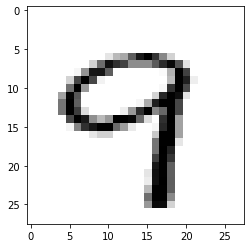

In [5]:
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print(' - Shape ', train.train_data.cpu().numpy().shape)
print(' - Max ', torch.max(train_data))
print(' - Min ', torch.min(train_data))
print(' - Mean ',torch.mean(train_data))
print(' - Std dev ', torch.std(train_data))
print(' - Var ', torch.var(train_data))

# Displaying images
dataiter = iter(train_dataloader)
images, labels = dataiter.next()

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

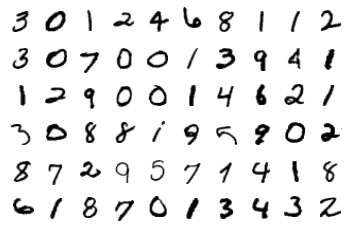

In [6]:
#Plot bunch of images
figure = plt.figure()
NUM_IMAGES = 60

for index in range(1,NUM_IMAGES+1):
    plt.subplot(6,10,index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')


# The Model

In [7]:

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 10, 3,padding=1),  # 28
            nn.ReLU(),
            nn.Dropout(0.10),
            nn.BatchNorm2d(10),
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(10, 16, 3, padding=1),  # 28
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.10),
            nn.MaxPool2d(2,2),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 10, 3, padding=1),  # 14
            nn.ReLU(),
            nn.Dropout(0.10),
            nn.BatchNorm2d(10),
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(10, 16, 3, padding=1),  # 14
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.10),
            nn.MaxPool2d(2,2),  # 7
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(16, 10, 3),  # 5
            nn.ReLU(),
            nn.Dropout(0.10),
            nn.BatchNorm2d(10),
        )

        self.conv6 = nn.Sequential(
            nn.Conv2d(10, 10, 3),  #3
            nn.ReLU(),
            nn.BatchNorm2d(10),
        )

        self.conv7 = nn.Sequential(
            nn.Conv2d(10, 10, 3),  #1
        )

    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = x.view(-1,10)
        return F.log_softmax(x, dim=-1)


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]             100
              ReLU-2           [-1, 10, 28, 28]               0
           Dropout-3           [-1, 10, 28, 28]               0
       BatchNorm2d-4           [-1, 10, 28, 28]              20
            Conv2d-5           [-1, 16, 28, 28]           1,456
              ReLU-6           [-1, 16, 28, 28]               0
       BatchNorm2d-7           [-1, 16, 28, 28]              32
           Dropout-8           [-1, 16, 28, 28]               0
         MaxPool2d-9           [-1, 16, 14, 14]               0
           Conv2d-10           [-1, 10, 14, 14]           1,450
             ReLU-11           [-1, 10, 14, 14]               0
          Dropout-12           [-1, 10, 14, 14]               0
      BatchNorm2d-13           [-1, 10, 14, 14]              20
           Conv2d-14           [-1, 16,

In [9]:
train_acc = []
test_acc = []
train_losses = []
test_losses = []

def train(model, device, train_dataloader, optimizer, epochs):
    model.train()
    pbar = tqdm(train_dataloader)
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)
        loss.backward()
        optimizer.step()

        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc=f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)



def test(model, device, test_dataloader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():

        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_dataloader.dataset)
    test_losses.append(test_loss)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset)))
    
    test_acc.append(100. * correct / len(test_dataloader.dataset))

In [10]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15

for epoch in range(EPOCHS):
    print('EPOCH - ', epoch)
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)

0%|          | 0/469 [00:00<?, ?it/s]EPOCH -  0
Loss=0.07433933764696121 Batch_id=468 Accuracy=92.96: 100%|██████████| 469/469 [00:15<00:00, 30.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]
Test set: Average loss: 0.0555, Accuracy: 9836/10000 (98.36%)

EPOCH -  1
Loss=0.04025143384933472 Batch_id=468 Accuracy=97.76: 100%|██████████| 469/469 [00:15<00:00, 30.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]
Test set: Average loss: 0.0427, Accuracy: 9874/10000 (98.74%)

EPOCH -  2
Loss=0.06448004394769669 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:15<00:00, 31.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]
Test set: Average loss: 0.0354, Accuracy: 9889/10000 (98.89%)

EPOCH -  3
Loss=0.05320625379681587 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:15<00:00, 31.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]
Test set: Average loss: 0.0347, Accuracy: 9882/10000 (98.82%)

EPOCH -  4
Loss=0.02246665023267269 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [

Text(0.5, 1.0, 'Test Accuracy')

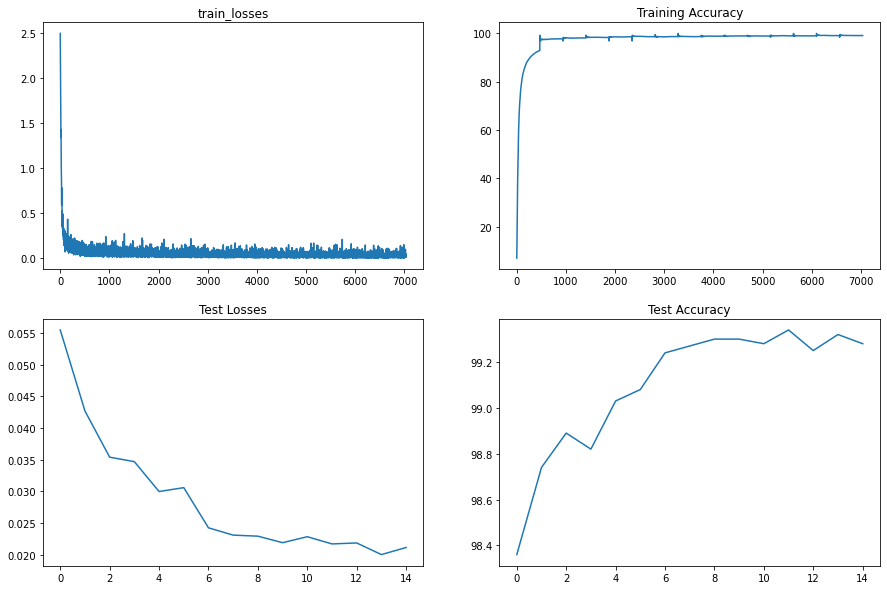

In [11]:
fig, axs = plt.subplots(2,2, figsize=(15,10))
axs[0,0].plot(train_losses)
axs[0,0].set_title('train_losses')
axs[0,1].plot(train_acc)
axs[0,1].set_title('Training Accuracy')
axs[1,0].plot(test_losses)
axs[1,0].set_title('Test Losses')
axs[1,1].plot(test_acc)
axs[1,1].set_title('Test Accuracy')